In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from numpy import linalg as LA
from scipy.sparse import csr_matrix
import seaborn as sns
from sklearn import decomposition, metrics, preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import (RandomForestClassifier, RandomForestRegressor, 
                              GradientBoostingClassifier, StackingClassifier)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import (accuracy_score, auc, average_precision_score,
                             classification_report, confusion_matrix, log_loss,
                             make_scorer, plot_precision_recall_curve,
                             plot_roc_curve, precision_recall_curve,
                             roc_auc_score, roc_curve, plot_confusion_matrix)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
%matplotlib inline

In [2]:
def grid_search_cv_and_test(model, grid_search_params, X_train, y_train, X_test, y_test):
    """
    Runs a GridSearchCV on the training set and evaluates the performance of the best estimator on 
    the testing set
    """
    gs = GridSearchCV(model, grid_search_params, verbose = 1, cv = 4, n_jobs = -1, scoring='f1')
    gs_results = gs.fit(X_train, y_train)
    print(gs_results.best_score_)
    print(gs_results.best_estimator_)
    print(gs_results.best_params_)
    roc = plot_roc_curve(gs_results.best_estimator_, X_test, y_test)
    precision_recall = plot_precision_recall_curve(gs_results.best_estimator_, X_test, y_test)
    plt.show()
    model_performance_evaluation(y_test, gs_results.best_estimator_.predict(X_test))
    
    return gs_results.best_estimator_

def model_performance_evaluation(y_test, y_pred):
    """
    simultaneously prints the confusion matrix and classification report
    """
    print("=== Confusion Matrix ===")
    print(confusion_matrix(y_test, y_pred))
    print('\n')
    print("=== Classification Report ===")
    print(classification_report(y_test, y_pred))
    print('\n')

In [3]:
relations_df = pd.read_csv("../data/relations_features.csv", delimiter="\t", index_col="src")

relations_df.head()

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,dt_1,dt_2,dt_3,dt_4,dt_5,dt_6,dt_7,dout_1,dout_2,dout_3,...,duni_6,duni_7,dnbi_1,dnbi_2,dnbi_3,dnbi_4,dnbi_5,dnbi_6,dnbi_7,n_bidir
src,,,,,,,,,,,,,,,,,,,,,
1,0,0,40,61,53,121,0,0,0,22,...,115,0,0,0,5,5,16,0,0,24
2,1,0,28,41,65,159,0,0,0,0,...,133,0,0,0,0,3,1,0,0,12
3,0,9,29,8,6,5,0,0,4,24,...,5,0,0,1,2,1,0,0,0,3
4,0,0,5,9,15,7,0,0,0,1,...,7,0,0,0,1,3,4,0,0,5
5,0,0,5,11,11,11,0,0,0,4,...,10,0,0,0,0,3,2,0,0,7


In [11]:
user_data_and_features_df = pd.read_csv("../data/usersdata_with_features.csv", 
                                        delimiter=",", index_col="userId").drop(["Unnamed: 0", 
                                                                                 'degree_1', 'in_degree_1', 'out_degree_1', 
                                                                                 'degree_2', 'in_degree_2', 'out_degree_2', 
                                                                                 'degree_3', 'in_degree_3', 'out_degree_3', 
                                                                                 'degree_4', 'in_degree_4', 'out_degree_4', 
                                                                                 'degree_5', 'in_degree_5', 'out_degree_5', 
                                                                                 'degree_6', 'in_degree_6', 'out_degree_6', 
                                                                                 'degree_7', 'in_degree_7', 'out_degree_7',], axis=1)

In [13]:
df = user_data_and_features_df.merge(relations_df, 
                           how='inner', left_index=True, right_index=True)

In [17]:
df = pd.concat([df, pd.get_dummies(df['sex'], prefix='sex', drop_first=True)], 
                        axis=1).drop(['sex'], axis=1)

In [18]:
# Assign weights to sample equal number of Spam and Ham
df["inv_value_count"] = 0
df["inv_value_count"][df.label == 1] = 1/df["label"].value_counts()[1]
df["inv_value_count"][df.label == 0] = 1/df["label"].value_counts()[0]
# to sample equal number of spam/ham we add weight with inv_value_count columns

/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [19]:
# to sample equal number of spam/ham we add weight with inv_value_count columns
df_sample = df.sample(n = 100000, weights = 'inv_value_count').drop(["inv_value_count"], axis=1)

In [20]:
graph_features_subset = df_sample.drop(['sex_M', 'timePassedValidation', 'ageGroup'], axis=1)

In [21]:
graph_features_subset.head()

,label,pagerank_1,pagerank_2,pagerank_3,pagerank_4,pagerank_5,pagerank_6,pagerank_7,triangles_count_1,triangles_count_2,...,duni_6,duni_7,dnbi_1,dnbi_2,dnbi_3,dnbi_4,dnbi_5,dnbi_6,dnbi_7,n_bidir
2411685,0,0.000001,0.000000e+00,NaN,NaN,NaN,1.000923e-06,0.000000,0.0,0.0,...,95,0,1,0,9,1,0,0,0,13
1233919,0,0.000001,0.000000e+00,NaN,8.338806e-07,NaN,NaN,0.000000,0.0,0.0,...,125,0,0,0,4,4,10,0,0,15
1166099,1,0.000000,5.218641e-07,NaN,NaN,0.000002,NaN,0.000006,0.0,0.0,...,269,1,0,0,0,51,169,1,0,364
2673156,1,0.000001,9.389650e-07,NaN,NaN,NaN,9.788383e-07,0.000000,0.0,0.0,...,137,0,0,0,1,4,0,0,0,7
4037281,0,0.000001,0.000000e+00,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,...,14,0,0,0,1,3,0,0,0,3


In [23]:
gX, gy = graph_features_subset.drop("label", axis=1), graph_features_subset[["label"]]
gX, gy = gX.values, gy.values
g_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
gX = g_imputer.fit_transform(gX)
gX_train, gX_test, gy_train, gy_test = train_test_split(gX, gy, test_size=0.2)


g_scaler = StandardScaler()
g_X_train = g_scaler.fit_transform(gX_train)
g_X_test = g_scaler.transform(gX_test)

## Random Forest

Fitting 4 folds for each of 3 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:   27.2s remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:   27.6s finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/model_selection/_search.py:741: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.685400690632816
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'bootstrap': True, 'max_depth': 15, 'n_estimators': 100}


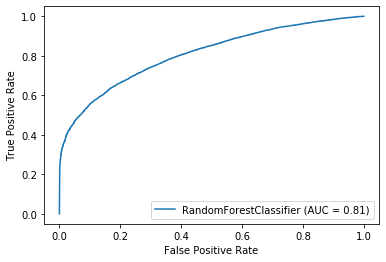

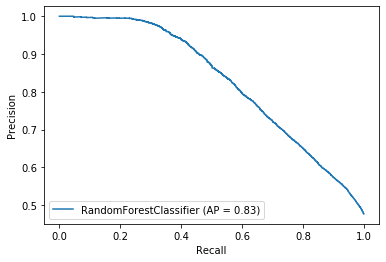

=== Confusion Matrix ===
[[8951 1513]
 [3769 5767]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.70      0.86      0.77     10464
           1       0.79      0.60      0.69      9536

    accuracy                           0.74     20000
   macro avg       0.75      0.73      0.73     20000
weighted avg       0.75      0.74      0.73     20000





RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=15, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [24]:
grid_params_rf = {
    'bootstrap': [True],
    'max_depth': [5, 10, 15],
    'n_estimators': [75, 100, 150]
}
grid_search_cv_and_test(model=RandomForestClassifier(), grid_search_params=grid_params_rf, 
                        X_train=gX_train, y_train=gy_train, X_test=gX_test, y_test=gy_test)

## XGBoost

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 29.0min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

0.6960375984904488
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)
{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100}


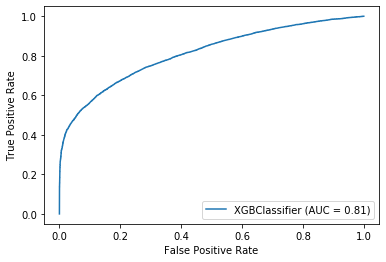

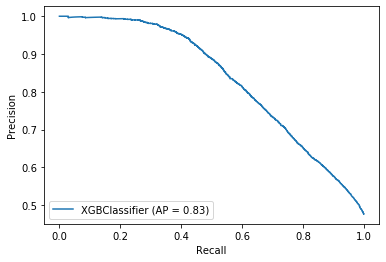

=== Confusion Matrix ===
[[8862 1602]
 [3535 6001]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.71      0.85      0.78     10464
           1       0.79      0.63      0.70      9536

    accuracy                           0.74     20000
   macro avg       0.75      0.74      0.74     20000
weighted avg       0.75      0.74      0.74     20000





XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [25]:
xgb = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
grid_params_xgb = {
    'max_depth': [5, 10],
    'n_estimators': [50, 100],
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search_cv_and_test(model=xgb, grid_search_params=grid_params_xgb, X_train=gX_train, y_train=gy_train,
                        X_test=gX_test, y_test=gy_test)

# Adding user data

In [26]:
X, y = df_sample.drop("label", axis=1), df_sample[["label"]]
X, y = X.values, y.values
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X = imputer.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Random Forest

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  6.2min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/model_selection/_search.py:741: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


0.7356047141934223
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=25, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
{'bootstrap': True, 'max_depth': 25, 'n_estimators': 300}


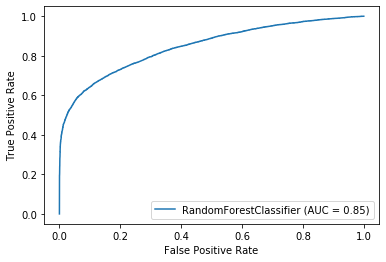

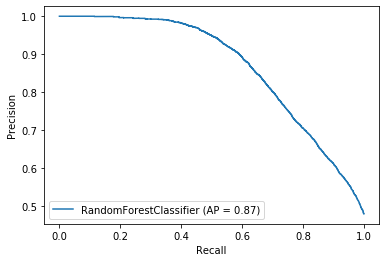

=== Confusion Matrix ===
[[9168 1254]
 [3207 6371]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.88      0.80     10422
           1       0.84      0.67      0.74      9578

    accuracy                           0.78     20000
   macro avg       0.79      0.77      0.77     20000
weighted avg       0.79      0.78      0.77     20000





In [27]:
grid_params_rf = {
    'bootstrap': [True],
    'max_depth': [17, 20, 25],
    'n_estimators': [200, 250, 300]
}
rf_best_estimator = grid_search_cv_and_test(model=RandomForestClassifier(), grid_search_params=grid_params_rf, 
                                            X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

## PCA + Random Forest

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  9.1min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/pipeline.py:352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.7154322613357652
Pipeline(memory=None,
         steps=[('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=17,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=19, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=120, n_jobs=None,
                                        oob_score=False, random_state=N

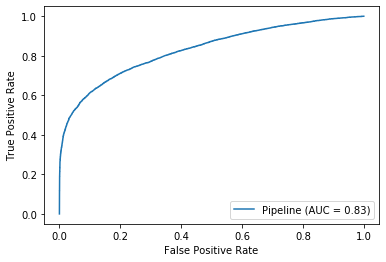

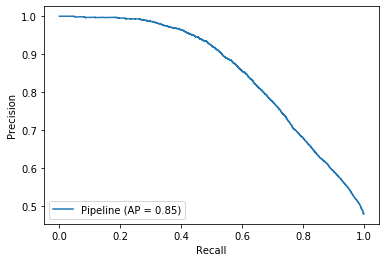

=== Confusion Matrix ===
[[9028 1394]
 [3369 6209]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.73      0.87      0.79     10422
           1       0.82      0.65      0.72      9578

    accuracy                           0.76     20000
   macro avg       0.77      0.76      0.76     20000
weighted avg       0.77      0.76      0.76     20000





Pipeline(memory=None,
         steps=[('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=17,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=19, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=120, n_jobs=None,
                                        oob_score=False, random_state=None,
              

In [28]:
pipe = Pipeline([
    ('PCA', PCA()),
    ('classifier', RandomForestClassifier())
])
grid_params_pca_rf = [
    {
        'PCA__n_components': [15, 17, 19],
        'classifier__bootstrap': [True],
        'classifier__max_depth': [17, 19],
        'classifier__n_estimators': [120, 150]
    }
]
grid_search_cv_and_test(model=pipe, grid_search_params=grid_params_pca_rf, X_train=X_train,
                       y_train=y_train, X_test=X_test, y_test=y_test)

## PCA + KNN

Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  2.9min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/pipeline.py:352: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


0.7147553051491724
Pipeline(memory=None,
         steps=[('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=21,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=29, p=2,
                                      weights='uniform'))],
         verbose=False)
{'PCA__n_components': 21, 'classifier__n_neighbors': 29, 'classifier__weights': 'uniform'}


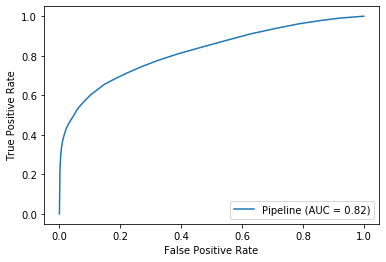

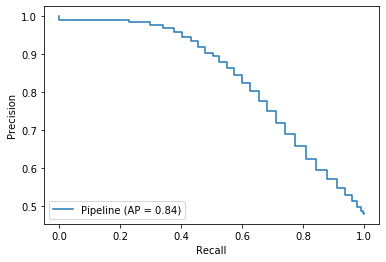

=== Confusion Matrix ===
[[8886 1536]
 [3302 6276]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.73      0.85      0.79     10422
           1       0.80      0.66      0.72      9578

    accuracy                           0.76     20000
   macro avg       0.77      0.75      0.75     20000
weighted avg       0.76      0.76      0.76     20000





Pipeline(memory=None,
         steps=[('PCA',
                 PCA(copy=True, iterated_power='auto', n_components=21,
                     random_state=None, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=None, n_neighbors=29, p=2,
                                      weights='uniform'))],
         verbose=False)

In [29]:
pipe = Pipeline([
    ('PCA', PCA()),
    ('classifier', KNeighborsClassifier())
])
grid_params_pca_knn = [
    {
        'PCA__n_components': [17, 19, 21],
        'classifier__n_neighbors': [27, 29, 31],
        'classifier__weights': ["uniform"]
    }
]
grid_search_cv_and_test(model=pipe, grid_search_params=grid_params_pca_knn, X_train=X_train,
                       y_train=y_train, X_test=X_test, y_test=y_test)

## XGBoost

Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  5.0min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7346263595343469
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 120}


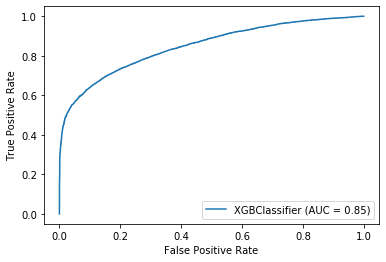

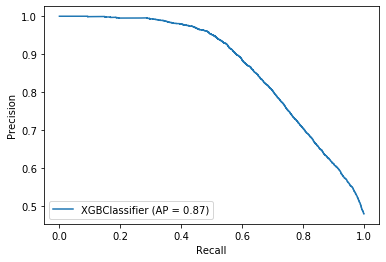

=== Confusion Matrix ===
[[9219 1203]
 [3279 6299]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.88      0.80     10422
           1       0.84      0.66      0.74      9578

    accuracy                           0.78     20000
   macro avg       0.79      0.77      0.77     20000
weighted avg       0.79      0.78      0.77     20000





XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, verbosity=1)

In [30]:
xgb = XGBClassifier(
    objective= 'binary:logistic',
    seed=42
)

grid_params_xgb = {
    'max_depth': [7, 9],
    'n_estimators': [100, 120],
    'learning_rate': [0.1, 0.05]
}

grid_search_cv_and_test(model=xgb, grid_search_params=grid_params_xgb, X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test)

## Gradient Boosting Classifier

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 53.1min finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/ensemble/_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7365489188881177
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 250}


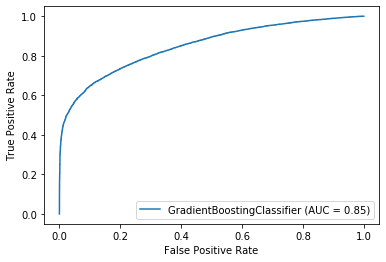

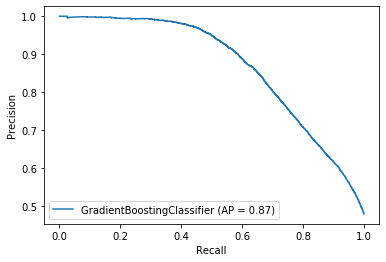

=== Confusion Matrix ===
[[9224 1198]
 [3220 6358]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.74      0.89      0.81     10422
           1       0.84      0.66      0.74      9578

    accuracy                           0.78     20000
   macro avg       0.79      0.77      0.77     20000
weighted avg       0.79      0.78      0.78     20000





GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=7,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [31]:
grid_params_gb = {
    'max_depth': [7, 9, 11],
    'n_estimators': [200, 250],
    'learning_rate': [0.05, 0.1]
}
grid_search_cv_and_test(model=GradientBoostingClassifier(), grid_search_params=grid_params_gb, X_train=X_train, y_train=y_train,
                        X_test=X_test, y_test=y_test)

## Ridge Regression

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.3s finished
/home/tariq/miniconda3/envs/ntds_2019/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:937: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7058397235373126
RidgeClassifier(alpha=5, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
{'alpha': 5}


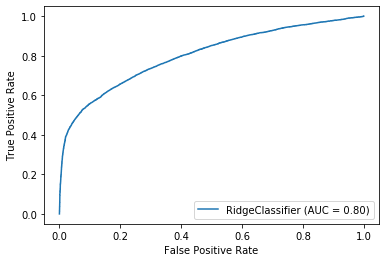

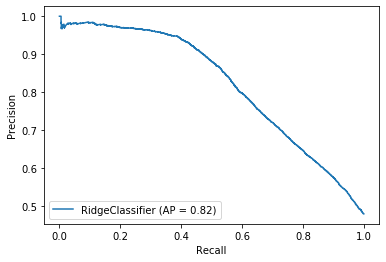

=== Confusion Matrix ===
[[7779 2643]
 [2845 6733]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.73      0.75      0.74     10422
           1       0.72      0.70      0.71      9578

    accuracy                           0.73     20000
   macro avg       0.73      0.72      0.72     20000
weighted avg       0.73      0.73      0.73     20000





In [32]:
grid_params_rc = {
    "alpha": [1.0, 0.1, 0.05, 0.5, 5]
}
ridge_best_estimator = grid_search_cv_and_test(model=RidgeClassifier(), grid_search_params=grid_params_rc, 
                                               X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)